# Load libraries


this notebook works !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

In [1]:
import sys

if ".." not in sys.path:
    sys.path.insert(0, "..")
from semi_analytical_halos.density_profile import Profile

In [2]:
from semi_analytical_halos.generate_smooth_halo import Smooth_halo

N_tot = 10000


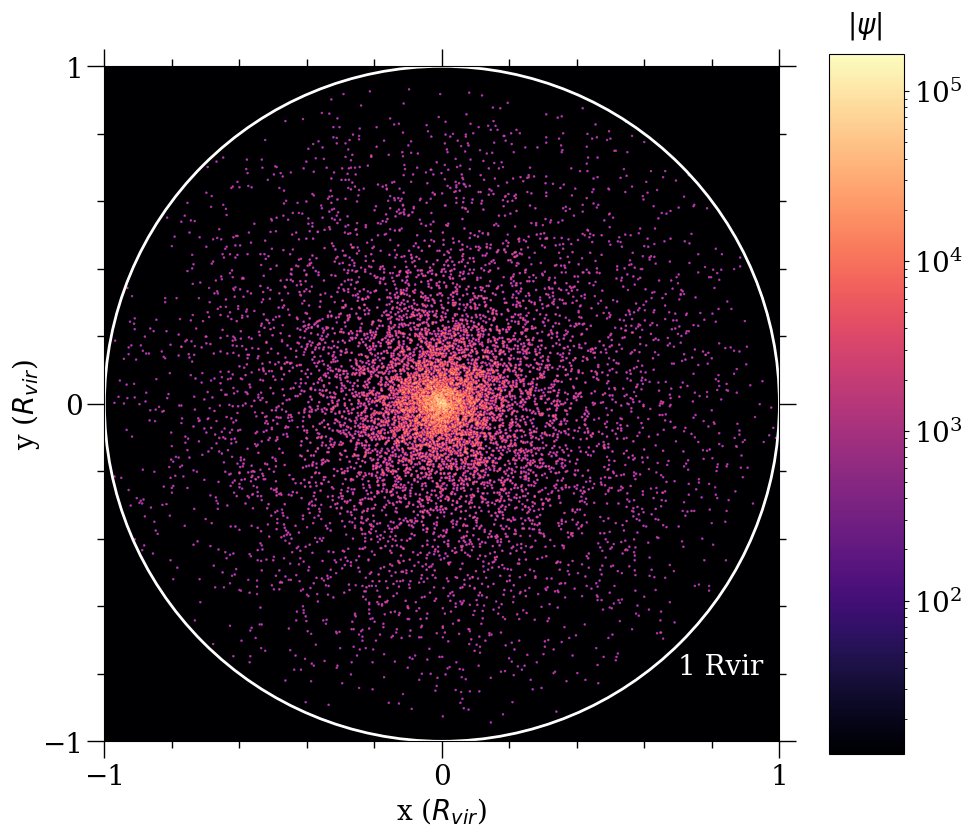

()

In [3]:
halo = Smooth_halo()
kind_profile = {"kind of profile": "abg",
                "concentration": 10,
                "alpha": 1, "beta": 3, "gamma": 1}
my_halo = halo.smooth_halo_creation() #kind_profile, b_ax=0.5, c_ax=0.5)
data = my_halo["data"]
print("N_tot =",my_halo["N_tot"])
#halo.plot_data(data[:,0],data[:,1])
halo.beauty_plot_colorbar(data)